In [1]:
import sys
sys.path.append("..")

from plotting_tools import * 

In [2]:
def load_prevalence_data(result_file, num_hh_sizes):
    df = pd.read_csv(result_file, sep=',')
    unique_sims = df['Sim'].unique()
    unique_t = df['t'].unique()
    num_sims = len(unique_sims)
    num_timesteps = len(unique_t)
    # Create a mapping from Sim to index (0-based row in matrix)
    sim_to_idx = {sim: idx for idx, sim in enumerate(unique_sims)}
    infection_matrices = {
        f'rel_infected_hhsize_{hh_size}': np.zeros((num_sims, num_timesteps))
        for hh_size in range(1, num_hh_sizes + 1)
    }
    
    # Index the DataFrame for faster access
    df.set_index(['Sim', 't'], inplace=True)

    # Fill matrices
    for (sim, t), row in df.iterrows():
        sim_idx = sim_to_idx[sim]
        t_idx = int(t)

        for hh_size in range(1, num_hh_sizes + 1):
            num_inf = row[f'NumInfected{hh_size}HH']
            num_agents = row[f'NumAgents{hh_size}HH']
            if num_agents > 0:
                infection_matrices[f'rel_infected_hhsize_{hh_size}'][sim_idx, t_idx] = num_inf / num_agents
                
    return num_timesteps, infection_matrices

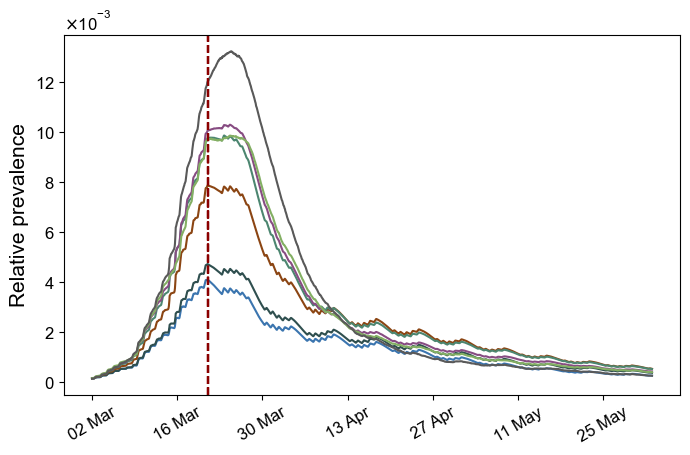

<Figure size 700x450 with 0 Axes>

In [ ]:
simulation_results = 'num_agents_infections_hh_size_ag_pop8.txt'
num_hh_sizes = 7

num_timesteps, prevalence_matrices = load_prevalence_data(simulation_results, num_hh_sizes)

used_colors = [c for c in ag_to_color_dict.values()] + [colors['Dark grey']]
t_lockdown = 24 * 19
figsize = (7, 4.5)
panel = [0.1, 0.13, 0.88, 0.8]            
# Plot relative infected per household size
fig = plt.figure(figsize=figsize)
ax = fig.add_axes(panel)
legend = {}
for hh_size in range(1, num_hh_sizes + 1):
    label = f'Household size {hh_size}'
    legend[label] = used_colors[hh_size - 1]
    matrix = prevalence_matrices[f'rel_infected_hhsize_{hh_size}']
    mean_vals = matrix.mean(axis=0)
    x = np.arange(num_timesteps)
    ax.plot(x, mean_vals, color=used_colors[hh_size - 1], label=label)
    ax.axvline(x=t_lockdown, color=colors['Dark red'], linestyle='--')
    # x-ticks positions
    xticks = np.arange(0, num_timesteps, 14*24)
    ax.set_xticks(xticks)
    # Convert xlabels to dates starting from March 2
    start_date = datetime(2020, 3, 2)
    labels = [(start_date + timedelta(hours=int(i))).strftime('%d %b') for i in xticks]
    # Set the labels
    ax.set_xticklabels(labels, rotation=30)
    formatter = ScalarFormatter(useMathText=True)
    formatter.set_scientific(True)
    formatter.set_powerlimits((-3, -3))
    ax.yaxis.set_major_formatter(formatter)
    ax.set_ylabel('Relative prevalence')
plt.show()
fig.savefig(f'prevalence_per_hh_size.png', dpi=dpi)
    
#Figure with legend only
patchList = []
for key in legend:
    data_key = patches.Patch(color=legend[key], label=key)
    patchList.append(data_key)

fig = plt.figure(figsize=figsize)
legend = fig.legend(handles=patchList, loc='center left', bbox_to_anchor=(0, 0.5), ncol = 3)
plt.show()
fig.savefig(f'legend_households.png', dpi=dpi)

In [4]:
def load_transmission_results(result_file_loctype, num_sims):
    # Load data
    output = pd.read_csv(result_file_loctype)

    # Determine number of time points using only the first simulation
    num_time_points = output.loc[output.Sim == 1, 't'].nunique()

    # Define categories
    categories = ['Total', 'Home', 'Work', 'School', 'Shop', 'Recreation']

    # Initialize result dictionary
    infection_matrices = {
        f'{cat}_new_inf': np.zeros((num_sims, num_time_points)) for cat in categories
    }

    # Map locType indices to category names and filter relevant rows
    output['Category'] = output['locType'].map(idx_to_loctype_dict)
    output = output[output['Category'].isin(categories)]

    # Process each simulation
    for sim in range(1, num_sims + 1):
        sim_output = output[output.Sim == sim]

        # Pivot to get time x category matrices
        pivot_new_inf = sim_output.pivot_table(
            index='t', columns='Category', values='NewInfections', fill_value=0
        )

        # Ensure all categories are present
        for cat in categories[1:]:  # exclude 'Total'
            if cat not in pivot_new_inf.columns:
                pivot_new_inf[cat] = 0

        # Reorder and convert to numpy arrays
        pivot_new_inf = pivot_new_inf[categories[1:]].to_numpy()

        # Compute totals
        total_new_inf = pivot_new_inf.sum(axis=1)

        # Insert into infection_matrices
        infection_matrices['Total_new_inf'][sim - 1] = total_new_inf

        for i, cat in enumerate(categories[1:]):
            infection_matrices[f'{cat}_new_inf'][sim - 1] = pivot_new_inf[:, i]
    return num_time_points, infection_matrices

<string>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


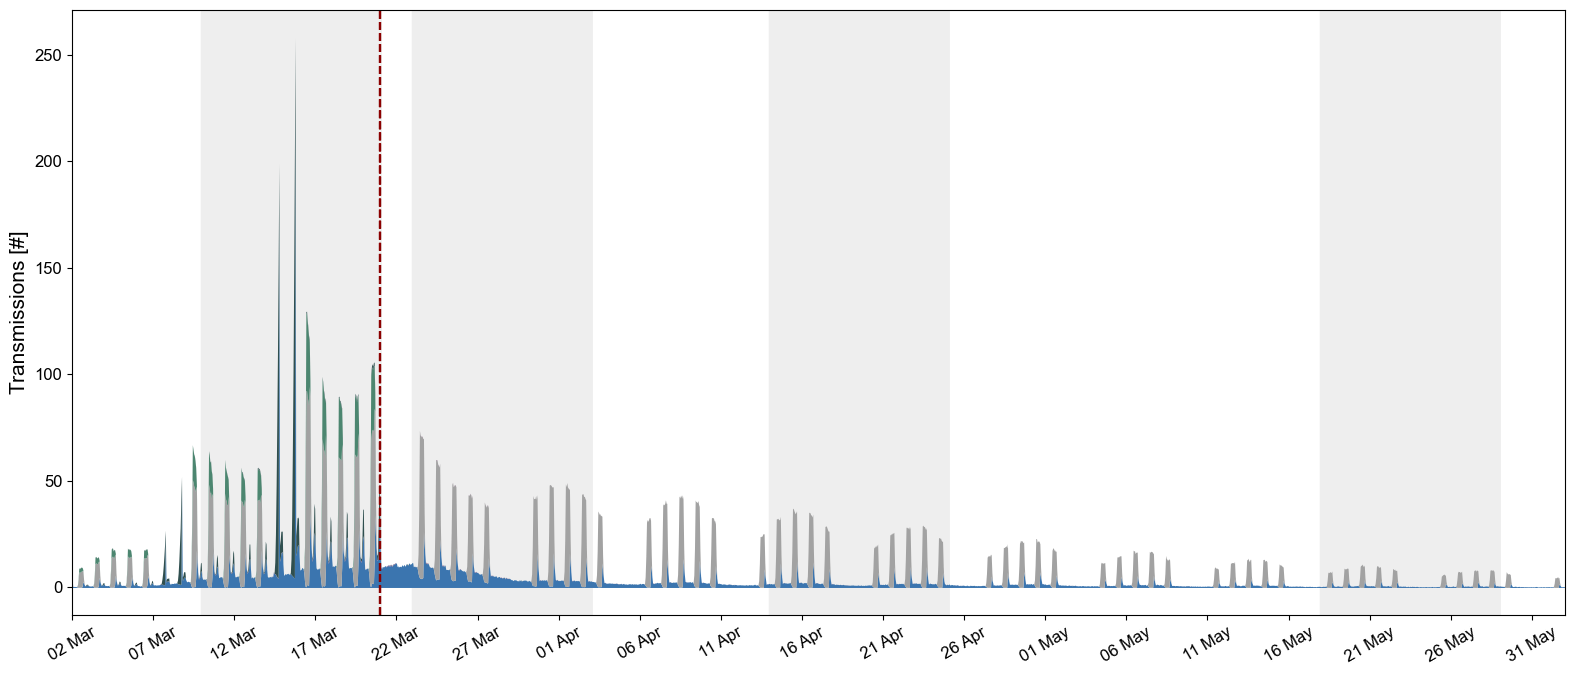

In [ ]:
result_file = 'num_agents_infections_loctype.txt'
num_sims = 100
num_time_points, infection_matrices = load_transmission_results(result_file, num_sims)

color_map = {
    'Total': 'black', 'Home': loctype_to_color_dict['Home'], 'Recreation': loctype_to_color_dict['Recreation'],
    'Work': loctype_to_color_dict['Work'], 'School': loctype_to_color_dict['School'], 'Shop': loctype_to_color_dict['Shop']
}
categories = ['Total', 'Home', 'Work', 'School', 'Shop', 'Recreation']

t_lockdown = 24 * 19
intervals = [(8*24, 19*24), (21*24, 32*24), (43*24, 54*24), (77*24, 88*24)]
# Plot new infections timeseries
figsize = (16, 7)
fig, ax = plt.subplots(figsize=figsize)
# Bottom values for stacked line plot
bottom = np.zeros(num_time_points)
for cat in categories:
    # Total number of new infections is not plotted
    if cat == 'Total':
        continue
    label = cat
    # Get submatrix for the considered two weeks
    matrix = infection_matrices[f'{cat}_new_inf'][:, :]
    # Get mean values
    mean_vals = matrix.mean(axis=0)
    # Percentiles are not plotted
    for tps in intervals:
        ax.axvline(x=tps[0], color=colors['Very light grey'], zorder=0)
        ax.axvline(x=tps[1], color=colors['Very light grey'], zorder=0)
        ax.axvspan(tps[0], tps[1], color=colors['Very light grey'], alpha=1, zorder=0)
    x = np.arange(0, num_time_points)
    ax.fill_between(x, bottom, bottom + mean_vals, color=color_map[label], lw=0, zorder=1)
    ax.set_xlim(0, num_time_points)
    bottom += mean_vals
    ax.axvline(x=t_lockdown, color=colors['Dark red'], linestyle='--', zorder=2)

# x-ticks positions
xticks = np.arange(0, num_time_points, 5*24)
ax.set_xticks(xticks)
# Convert xlabels to dates starting from March 1
start_date = datetime(2020, 3, 2)
labels = [(start_date + timedelta(hours=int(i))).strftime('%d %b') for i in xticks]
# Set the labels
ax.set_xticklabels(labels, rotation=30)
ax.set_ylabel('Transmissions [#]')
plt.tight_layout(rect=[0, 0, 1, 1])
plt.show()
fig.savefig(f'transmissions.png', dpi=dpi)

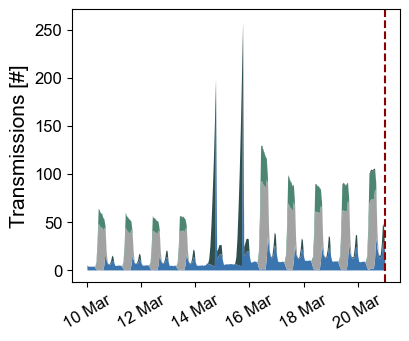

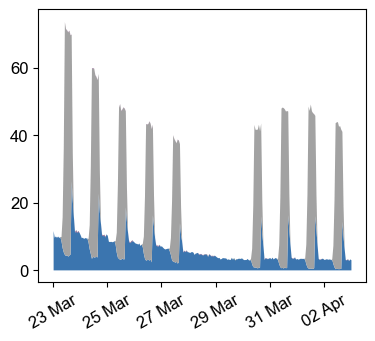

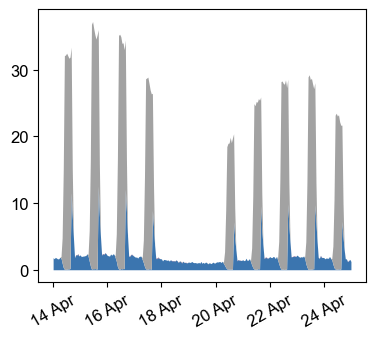

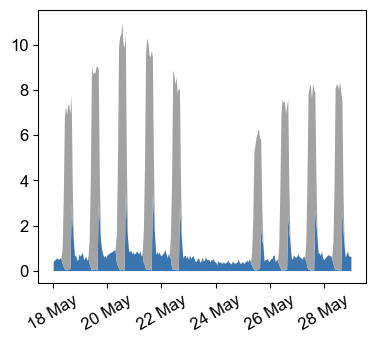

In [ ]:
figsize = (4.2, 3.5)
for index, tps in enumerate(intervals):
    fig = plt.figure(figsize=figsize)
    ax = fig.add_axes([0.2, 0.2, 0.78, 0.78])
    # Bottom values for stacked line plot
    bottom = np.zeros(tps[1] - tps[0] + 1)
    for cat in categories:
        # Total number of new infections is not plotted
        if cat == 'Total':
            continue
        label = cat
        # Get submatrix for the considered two weeks
        matrix = infection_matrices[f'{cat}_new_inf'][:, tps[0]:(tps[1]+1)]
        # Get mean values
        mean_vals = matrix.mean(axis=0)
        x = np.arange(tps[0], (tps[1]+1))
        ax.fill_between(x, bottom, bottom + mean_vals, color=color_map[label], lw=0)
        bottom += mean_vals
    if(t_lockdown >= tps[0] and t_lockdown < tps[1] + 1):
        ax.axvline(x=t_lockdown, color=colors['Dark red'], linestyle='--')
    
    # x-ticks positions
    xticks = np.arange(tps[0], tps[1] + 1, 2*24)
    ax.set_xticks(xticks)
    # Convert xlabels to dates starting from March 2
    start_date = datetime(2020, 3, 2)
    labels = [(start_date + timedelta(hours=int(i))).strftime('%d %b') for i in xticks]
    # Set the labels
    ax.set_xticklabels(labels, rotation=30)
    if(index == 0):
        ax.set_ylabel('Transmissions [#]')
    fig.savefig(f'transmissions_tp_{tps[0]}and{tps[1]}.png', dpi=dpi)